# Boer-Mulders Analysis

In [1]:
import sys
import os;os.chdir('../')
import itertools as it
import numpy as np
import pandas as pd
import pylab as py
from  matplotlib import rc
from matplotlib.colors import LogNorm
%matplotlib inline
from tools.tools import save,load,lprint,load_config
from tools.bar import BAR
from fitlab.resman import RESMAN
from fitlab.parman import PARMAN
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text',usetex=True)

In [2]:
conf=load_config('inputs/boermulders.py')
conf['resman']=RESMAN(conf)
conf['resman'].get_residuals(conf['parman'].par);

loading sidis data sets 5023

## Data vs Theory

In [89]:
tabs=pd.concat([pd.DataFrame(conf['resman'].sidisres.tabs[idx]) for idx in conf['resman'].sidisres.tabs.keys()])

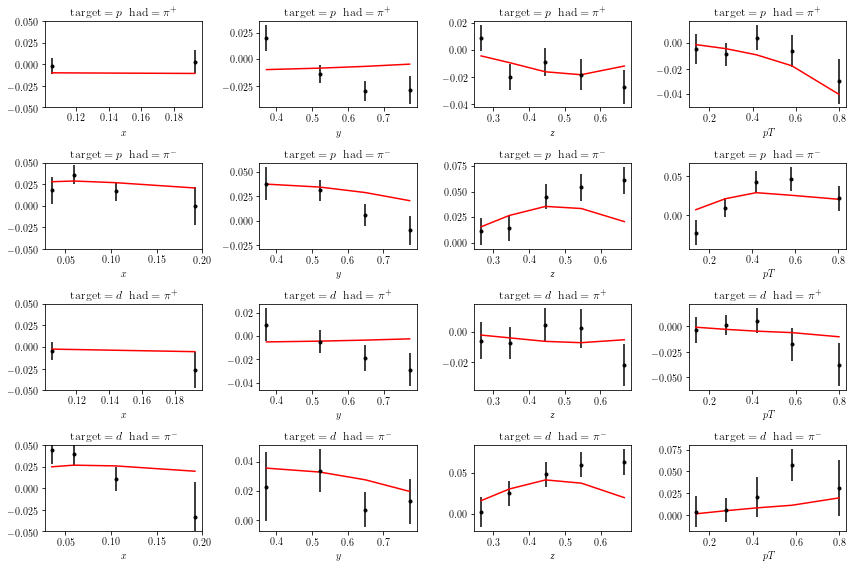

In [122]:
def plot(ax,axis,tar,had):
    data=tabs.query('axis=="%s" and target=="%s" and hadron=="%s" '%(axis,tar,had))
    if axis=='pt': axis='pT'
    ax.errorbar(data[axis],data['value'],yerr=data['alpha'],fmt='k.')
    ax.plot(data[axis],data['thy'],'r-')
    if tar=='proton': star='p'
    if tar=='deuteron': star='d'
    if had=='pi+': shad=r'\pi^+'
    if had=='pi-': shad=r'\pi^-'
    ax.set_title(r'${\rm target}=%s~~{\rm had}=%s$'%(star,shad))
    ax.set_xlabel(r'$%s$'%axis)
    if axis=='x': ax.set_ylim(-0.05,0.05)

nrows,ncols=4,4
py.figure(figsize=(ncols*3,nrows*2))

cnt=0
for tar in ['proton','deuteron']:
    for had in ['pi+','pi-']:
        for axis  in ['x','y','z','pt']:
            cnt+=1
            ax=py.subplot(nrows,ncols,cnt)
            plot(ax,axis,tar,had)
py.tight_layout()

## Boer-Mulders

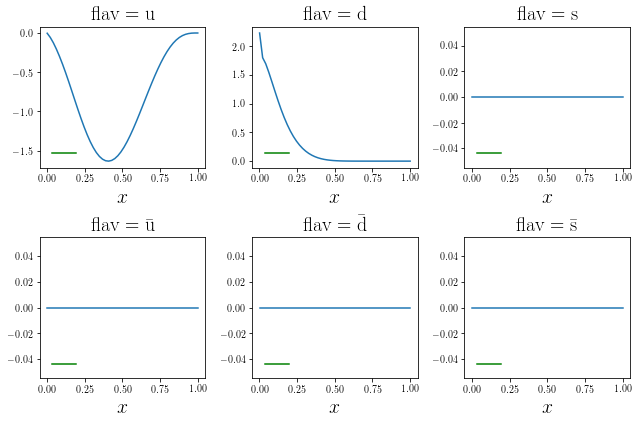

In [106]:
def plot(ax,iflav):
    X=np.linspace(1e-3,1)
    Q2=1
    XF=[x*conf['boermulders'].get_C(x,Q2,target='p')[iflav] for x in X]
    ax.plot(X,XF)
    if iflav==1: ax.set_title(r'${\rm flav=u}$',size=20)
    if iflav==3: ax.set_title(r'${\rm flav=d}$',size=20)
    if iflav==5: ax.set_title(r'${\rm flav=s}$',size=20)
    if iflav==2: ax.set_title(r'${\rm flav=\bar{u}}$',size=20)
    if iflav==4: ax.set_title(r'${\rm flav=\bar{d}}$',size=20)
    if iflav==6: ax.set_title(r'${\rm flav=\bar{s}}$',size=20)
    ax.set_xlabel(r'$x$',size=20)
    xmin=np.amin(tabs.x.values)
    xmax=np.amax(tabs.x.values)
    ymin,ymax=ax.get_ylim()
    dy=ymax-ymin
    ax.plot([xmin,xmax],[ymin+dy*0.1,ymin+dy*0.1],'g-')
    ax.set_ylim(ymin,ymax)
    
nrows,ncols=2,3
py.figure(figsize=(ncols*3,nrows*3))
cnt=0
for iflav in [1,3,5,2,4,6]:
    cnt+=1
    ax=py.subplot(nrows,ncols,cnt)
    plot(ax,iflav)
py.tight_layout()

## Collins

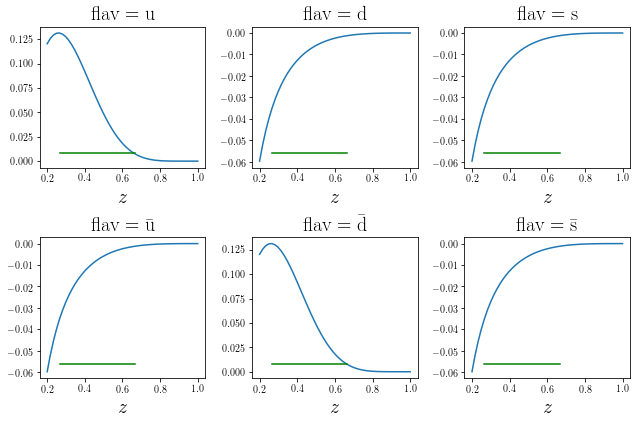

In [119]:
def plot(ax,iflav):
    Z=np.linspace(0.2,1)
    Q2=1
    ZF=[conf['collins'].get_C(z,Q2,hadron='pi+')[iflav] for z in Z]
    ax.plot(Z,ZF)
    if iflav==1: ax.set_title(r'${\rm flav=u}$',size=20)
    if iflav==3: ax.set_title(r'${\rm flav=d}$',size=20)
    if iflav==5: ax.set_title(r'${\rm flav=s}$',size=20)
    if iflav==2: ax.set_title(r'${\rm flav=\bar{u}}$',size=20)
    if iflav==4: ax.set_title(r'${\rm flav=\bar{d}}$',size=20)
    if iflav==6: ax.set_title(r'${\rm flav=\bar{s}}$',size=20)
    ax.set_xlabel(r'$z$',size=20)
    zmin=np.amin(tabs.z.values)
    zmax=np.amax(tabs.z.values)
    ymin,ymax=ax.get_ylim()
    dy=ymax-ymin
    ax.plot([zmin,zmax],[ymin+dy*0.1,ymin+dy*0.1],'g-')
    ax.set_ylim(ymin,ymax)
    
nrows,ncols=2,3
py.figure(figsize=(ncols*3,nrows*3))
cnt=0
for iflav in [1,3,5,2,4,6]:
    cnt+=1
    ax=py.subplot(nrows,ncols,cnt)
    plot(ax,iflav)
py.tight_layout()